In [86]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import os, sys
import cftime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

## Data

In [87]:
def read_csv(file_path, filename, varname):
    """
    Reads a CSV file, skips the first line and converts into into xarray.
    """
    ds = pd.read_csv(file_path+filename, skiprows=1, header=None, names=['time', varname], na_values=['NaN',-9999])
    ds['time'] = pd.to_datetime(ds['time'], format='%Y-%m-%d')

    ds = ds.set_index('time')
    ds = ds.to_xarray()
    ds['time'] = ds['time'].astype('datetime64[ns]')
    ds[varname] = ds[varname].astype('float32')

    return ds

def read_csv2(filepath):
    """
    Reads a CSV file and converts it to an xarray Dataset.
    """

    df = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    
    df.columns = ['time', 'q']
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
    df.set_index('time', inplace=True)
    ds = df.to_xarray()
    
    return ds

def anom(xarr):
    #monthly mean anomaly (No-detrened)

    xarr_clm = xarr.groupby('time.month').mean('time')
    xarr_ano = xarr.groupby('time.month') - xarr_clm
    return xarr_ano, xarr_clm

In [88]:
path = '/home/amnd25/Desktop/Milano/Test_CDP_PhD/'

dmi = read_csv(path,'dmi.had.long.csv','dmi')
mei = read_csv(path,'mei.ext.long.csv','mei') # multivariate ENSO index
nao = read_csv(path,'nao.long.csv','nao')
nino3 = read_csv(path,'nino3.long.anom.csv','nino3')
nino4 = read_csv(path,'nino4.long.anom.csv','nino4')
nino12 = read_csv(path,'nino12.long.anom.csv','nino12')
nino34 = read_csv(path,'nino34.long.anom.csv','nino34')
pdo = read_csv(path,'pdo.timeseries.sstens.csv','pdo') # Pacific Decadal Oscillation
soi = read_csv(path,'soi.long.csv','soi') # Southern Oscillation Index
tsa = read_csv(path,'tsa.long.csv','tsa') # Tropical Southern Atlantic

data_names = ['dmi', 'mei', 'nao', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'tsa'] # 10 climate indices
data_list =[dmi, mei, nao, nino3, nino4, nino12, nino34, pdo, soi, tsa]

In [89]:
streamflow = read_csv2(path+'Zambezi_at_BigTree_VicFalls_obs_discharge.txt')

streamflow_anom, streamflow_clm = anom(streamflow.q)

In [90]:
streamflow.q

<xarray.DataArray 'q' (time: 34252)> Size: 274kB
array([ 100.,  100.,  100., ..., 1671., 1635., 1587.])
Coordinates:
  * time     (time) datetime64[ns] 274kB 1924-10-01 1924-10-02 ... 2018-07-11

In [91]:
data_names = ['nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi']
data_list =[nino3, nino4, nino12, nino34, pdo, soi]
data_list_time_cropped = [ds.sel(time=slice('1924-10-01', '2018-07-11')) for ds in data_list]

## Modello

In [ ]:
window_size = 24
lag = 3
forecast_horizon = 1

monthly_streamflow = streamflow.q.resample(time='MS').mean('time')
monthly_streamflow = monthly_streamflow.dropna('time')

optimal_lags = {
    'nino3': 2,
    'nino4': 1,
    'nino12': 2,
    'nino34': 2,
    'pdo': 4,
    'soi': 4,}

climate_matrix = [] 

for nome, ds in zip(data_names, data_list_time_cropped):
    index_monthly = ds[nome].resample(time='MS').mean('time') # Make sure that they are monthly
    index_monthly = index_monthly.shift(time=optimal_lags[nome])  # Shift the index according to the optimal lag
    index_monthly = index_monthly.dropna('time') # Align with streamfow
    climate_matrix.append(index_monthly) 

climate_concat = xr.concat(climate_matrix, dim='variable') # Concatenate all climate indices along a new dimension
climate_concat['variable'] = data_names
climate_df = climate_concat.transpose('time', 'variable').to_pandas() # Transpose to have time as index and variables as columns
# We transpose because we want to align the climate indices with the streamflow time series
climate_df.columns = data_names

streamflow_series = monthly_streamflow.to_pandas()
climate_df, streamflow_aligned = climate_df.align(streamflow_series, join='inner', axis=0) # join='inner' to keep only the common dates

In [93]:
df = pd.concat([streamflow_aligned, climate_df], axis=1)
df = df.dropna()

X = []
y = []
dates = []

for i in range(window_size, len(df) - lag - forecast_horizon + 1):
    # Input features: 24 mesi di dati passati (inclusi tutti i 7 input: 1 streamflow + 6 climate indices)
    X_window = df.iloc[i - window_size:i].values  # shape (24, 7)
    
    # Target: valore della portata a t + lag (solo 1 valore, quindi shape (1,))
    y_target = df.iloc[i + lag]['q']  # singolo valore

    # Data corrispondente alla previsione
    prediction_date = df.index[i + lag]
    
    X.append(X_window)
    y.append(y_target)
    dates.append(prediction_date)
    
X = np.array(X)  # shape (samples, 24, 7)
y = np.array(y)  # shape (samples,)

### Splitting training/testing

In [94]:
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

### Standardization

In [95]:
# Inizializza uno scaler per ogni feature (7 in totale)
scalers = []
X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)

for i in range(X_train.shape[2]):  # per ogni feature
    scaler = StandardScaler()
    
    # Adatta solo sul training
    X_train_feat = X_train[:, :, i].reshape(-1, 1)
    scaler.fit(X_train_feat)
    
    # Trasforma train e test
    X_train_scaled[:, :, i] = scaler.transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train[:, :, i].shape)
    X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test[:, :, i].shape)
    
    scalers.append(scaler)  # salva lo scaler per usare più avanti se servisse

# Anche y deve essere standardizzato
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

### Model definition

In [96]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))  # Output singolo: previsione della portata a t+3

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/home/amnd25/anaconda3/envs/milano/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [97]:
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=15, factor=0.5, min_lr=1e-6)

In [98]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop, reduce_lr],
    shuffle=False
)


Epoch 1/100


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8254 - val_loss: 0.7282 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6687 - val_loss: 0.5873 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5580 - val_loss: 0.5124 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5138 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4457 - val_loss: 0.3844 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3970 - val_loss: 0.3544 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3542 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3273 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3308 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 10/100
55/55 ━━━━━━━━━━━━

### Predictions

In [99]:
y_pred_scaled = model.predict(X_test_scaled).flatten()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


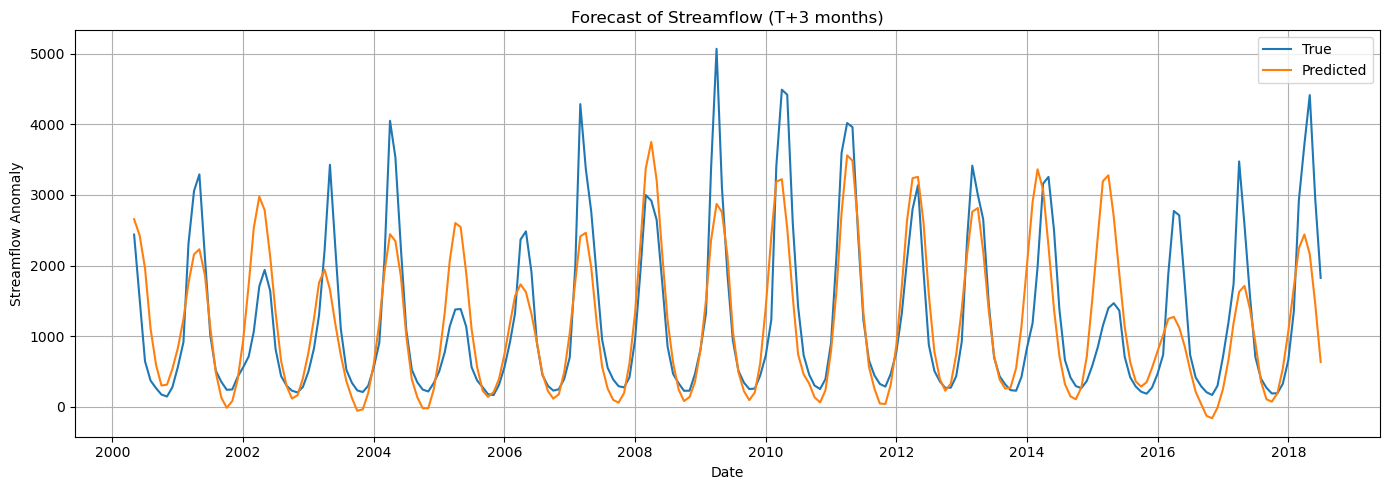

In [100]:
plt.figure(figsize=(14, 5))
plt.plot(dates_test, y_test_original, label='True')
plt.plot(dates_test, y_pred, label='Predicted')
plt.title("Forecast of Streamflow (T+3 months)")
plt.xlabel("Date")
plt.ylabel("Streamflow Anomaly")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


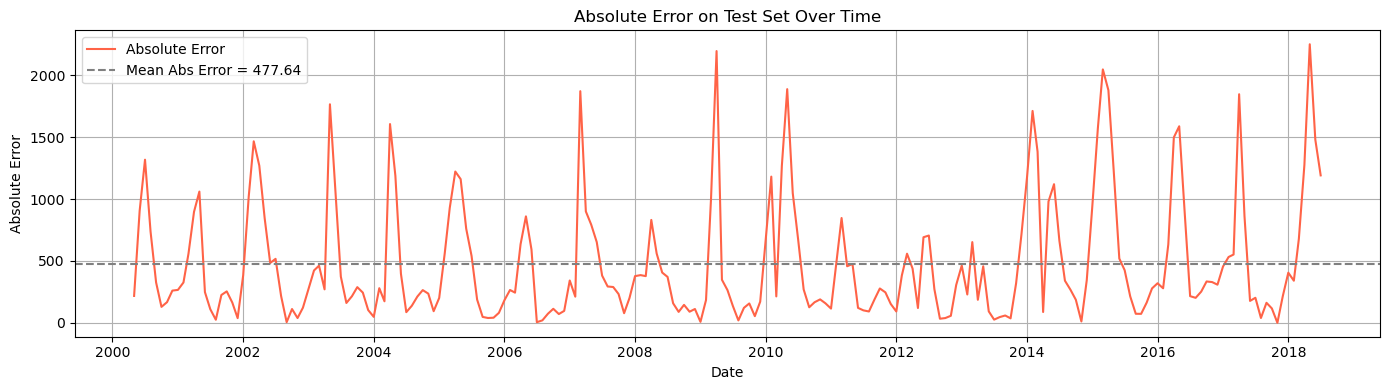

In [101]:
error = np.abs(y_pred - y_test_original)  # errore assoluto

plt.figure(figsize=(14, 4))
plt.plot(dates_test, error, color='tomato', label='Absolute Error')
plt.axhline(error.mean(), color='gray', linestyle='--', label=f'Mean Abs Error = {error.mean():.2f}')
plt.title("Absolute Error on Test Set Over Time")
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


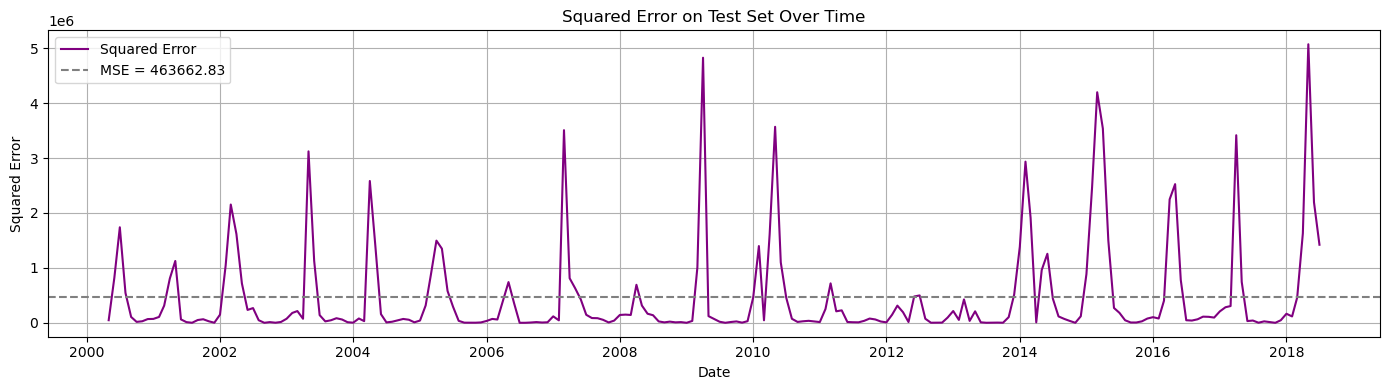

In [102]:
squared_error = (y_pred - y_test_original) ** 2

plt.figure(figsize=(14, 4))
plt.plot(dates_test, squared_error, color='purple', label='Squared Error')
plt.axhline(squared_error.mean(), color='gray', linestyle='--', label=f'MSE = {squared_error.mean():.2f}')
plt.title("Squared Error on Test Set Over Time")
plt.xlabel("Date")
plt.ylabel("Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
